In this notebook we will analyse the data and also do sentiment classification and find out which model performs best

In [1]:
#Importing important packages

In [2]:
import pandas as pd
import re,string
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
df = pd.read_csv("sample30.csv")
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


# Data cleaning and analysis

In [4]:
#Dropping id, reviews_date since id is related to product name and we dont need reviews_date for analysis

In [5]:
df.drop(['id','reviews_date'],axis=1,inplace=True)

Data Pre-Processing

In [6]:
df.shape

(30000, 13)

In [7]:
df.dtypes

brand                   object
categories              object
manufacturer            object
name                    object
reviews_didPurchase     object
reviews_doRecommend     object
reviews_rating           int64
reviews_text            object
reviews_title           object
reviews_userCity        object
reviews_userProvince    object
reviews_username        object
user_sentiment          object
dtype: object

In [8]:
df.isnull().sum()

brand                       0
categories                  0
manufacturer              141
name                        0
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

Since we shall be using user_sentiment for sentiment analysis , let's drop the rows having null value in it. Since we shall use reviews_username for recommendation system, let's remove the rows containing null values in it too.

In [9]:
df = df[df.reviews_username.isnull()!=True]
df.shape

(29937, 13)

In [10]:
df = df[df.user_sentiment.isnull()!=True]
df.shape

(29936, 13)

In [11]:
df['reviews_rating'].unique()

array([5, 1, 3, 4, 2], dtype=int64)

We see that there only five values for rating ie 1-5. 

In [12]:
df['reviews_title'].unique()

array(['Just Awesome', 'Good', 'Disappointed', ...,
       'Hair is so smooth after use', 'Perfect for my oily hair!',
       'Conditioned into healthy'], dtype=object)

We see there are multiple reviews title since this is on user.

In [13]:
df['reviews_rating'].value_counts().sort_values(ascending=False)

5    20791
4     6010
1     1373
3     1344
2      418
Name: reviews_rating, dtype: int64

We see that around 20k people have given a rating of 5.

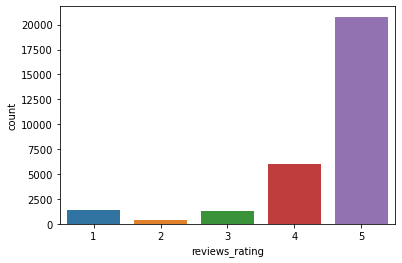

In [14]:
sns.countplot(df['reviews_rating'])
plt.show()

In [15]:
df['reviews_didPurchase'].value_counts().sort_values(ascending=False)

False    14497
True      1434
Name: reviews_didPurchase, dtype: int64

We see that only 1434 people have actually purchased products present in our data.

In [16]:
df['reviews_didPurchase'].isnull().sum()

14005

In [17]:


len(df['brand'].unique())



214

We have data of 214 brands

In [18]:


df['brand'].value_counts().sort_values(ascending=False)[:10]



Clorox                  10565
Warner Home Video        3325
Disney                   1199
L'oreal Paris            1186
FOX                       887
Burt's Bees               881
Sony Pictures             845
Summit Entertainment      813
Nexxus                    692
Universal Home Video      668
Name: brand, dtype: int64

In [19]:
df.groupby('brand')['reviews_rating'].agg(['mean','count']).sort_values(by='count',ascending=False)[:10]

,mean,count
brand,,
Clorox,4.824326,10565
Warner Home Video,4.350677,3325
Disney,4.687239,1199
L'oreal Paris,4.026981,1186
FOX,4.335964,887
Burt's Bees,4.650397,881
Sony Pictures,4.674556,845
Summit Entertainment,4.585486,813
Nexxus,1.354046,692


We see that Nexxus has lowest rating in the top 10 brands for which people have given most reviews

In [20]:
len(df['categories'].unique())

270

In [21]:
df['categories'].value_counts().sort_values(ascending=False)[:5]

Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Cleaning & Janitorial Supplies,Cleaners & Disinfectants,Cleaning Wipes & Pads,Cleaning Solutions,Housewares,Target Restock,Food & Grocery,Paper Goods,Wipes,All Purpose Cleaners    8525
Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys                                                                                                                                                                                                                                                                                                                                                                                                   3325
Household Chemicals,Household Cleaners,Bath & 

Now that we have performed basic analysis on data, let us do text processing for the columns that we shall use for sentiment analysis.

# Text pre-procesing

In [22]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    #For removing punctuation
    text = str(text).translate(str.maketrans('', '', string.punctuation))
    #For removing number and special characters
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]'
    text = re.sub(pattern, ' ', text)
    return text

In [23]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text):
    text = clean_text(text)
    sent = [wordnet_lemmatizer.lemmatize(word) for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
    return " ".join(sent)

First we will combine reviews title and text, to perform sentiment analysis on it. Hence, concatenating both columns

In [24]:
df['reviews_title_text'] = df["reviews_title"] + df["reviews_text"]
df.reviews_title_text

0        Just Awesomei love this album. it's very good....
1        GoodGood flavor. This review was collected as ...
2                                         GoodGood flavor.
3        DisappointedI read through the reviews on here...
4        IrritationMy husband bought this gel for us. T...
                               ...                        
29995    Softness!!I got this conditioner with Influens...
29996    I love itI love it , I received this for revie...
29997    Hair is so smooth after useFirst of all I love...
29998    Perfect for my oily hair!I received this throu...
29999    Conditioned into healthyI received this produc...
Name: reviews_title_text, Length: 29936, dtype: object

In [25]:
df.reviews_title_text.dtype

dtype('O')

In [26]:
df.reviews_title_text[df.reviews_title_text.isna()]

1239     NaN
1441     NaN
1442     NaN
1443     NaN
1444     NaN
        ... 
28790    NaN
28791    NaN
28792    NaN
28793    NaN
28794    NaN
Name: reviews_title_text, Length: 189, dtype: object

In [27]:
df = df[df.reviews_title_text.isna()!=True]

In [28]:
df.to_csv("df.csv")

In [29]:
df.reviews_title_text[df.reviews_title_text.isna()]

Series([], Name: reviews_title_text, dtype: object)

Since the data type in title text is string, hence changing the same.

In [30]:
#df.reviews_title_text = df.reviews_title_text.astype(str)

In [31]:
!pip install swifter
import swifter

df_clean = pd.DataFrame()
df_clean['reviews_title_text'] = df.reviews_title_text.swifter.apply(clean_text)

You should consider upgrading via the 'c:\users\pbabbar\anaconda3\python.exe -m pip install --upgrade pip' command.


Pandas Apply:   0%|          | 0/29747 [00:00<?, ?it/s]

For performing sentiment analysis, we will convert the sentiment into 0 and 1. 1 for positive and 0 for negative.

In [32]:
df['sentiment_binary'] = df.user_sentiment.replace({'Positive':1,'Negative':0})
df['sentiment_binary'].head()

0    1
1    1
2    1
3    0
4    0
Name: sentiment_binary, dtype: int64

In [33]:
# Spliting into X & y
X = df_clean['reviews_title_text'].values
y = df.sentiment_binary

# Building a TF IDF matrix out of the corpus of reviews
from sklearn.feature_extraction.text import TfidfVectorizer
td = TfidfVectorizer(max_features = 4500)
X = td.fit_transform(X).toarray()

In [34]:
df_clean.isna().sum()

reviews_title_text    0
dtype: int64

In [35]:
'''df['vectorized_reviews_title_text'] = X.tolist()
df_clean['vectorized_reviews_title_text'] = df['vectorized_reviews_title_text']'''

"df['vectorized_reviews_title_text'] = X.tolist()\ndf_clean['vectorized_reviews_title_text'] = df['vectorized_reviews_title_text']"

In [36]:
df_clean['name']=df['name']

We are saving this dataframe for uses in further notebooks

In [37]:
df_clean.to_csv("df_clean.csv")

### Text classification

In [38]:
# Splitting into training & test subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 42)

In [39]:
df['sentiment_binary'].value_counts(normalize=True)

1    0.887888
0    0.112112
Name: sentiment_binary, dtype: float64

Handling positive and negative imblance

In [40]:
#Since there is a data imbalance, we use technique called SMOTE to make data balanced.
from imblearn.over_sampling import SMOTE
from collections import Counter
#We only apply this technique on train data

counter = Counter(y_train)
print('Before',counter)

smt = SMOTE()

X_train_sm,y_train_sm = smt.fit_resample(X_train,y_train)

counter = Counter(y_train_sm)
print('After ',counter)

Before Counter({1: 18468, 0: 2354})
After  Counter({1: 18468, 0: 18468})


#### First applying Logistic regression on data with smote and data without smote

In [41]:
# Logistic Regression
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

clf = LogisticRegression(random_state=42).fit(X_train, y_train)
y_pred_logreg = clf.predict(X_test)

clf_sm = LogisticRegression(random_state=42,max_iter=1000).fit(X_train_sm, y_train_sm)
y_pred_logreg_sm = clf_sm.predict(X_test)


#SAVE MODEL
pickle.dump(clf, open("logreg_model.pkl", "wb"))
pickle.dump(clf_sm, open("logreg_model_sm.pkl", "wb"))

Let us create a dataframe to hold model evaluation scores.

- Since we are classifying the data, for us the best scores will be preceision and recall , not accuracy to check our model performance. He we shall go with the same.

In [42]:
df_sentiment_scores = pd.DataFrame(columns=['Method','Precision_normal','Recall_Normal','Precision_SMOTE','Recall_SMOTE'])

In [43]:
from sklearn.metrics import precision_score,recall_score,confusion_matrix
dict_temp =  {'Method':'LogReg','Precision_normal':precision_score(y_test, y_pred_logreg),'Recall_Normal':recall_score(y_test, y_pred_logreg),'Precision_SMOTE':precision_score(y_test, y_pred_logreg_sm),'Recall_SMOTE':recall_score(y_test, y_pred_logreg_sm)}
df_sentiment_scores = df_sentiment_scores.append(dict_temp,ignore_index=True)
df_sentiment_scores
  

,Method,Precision_normal,Recall_Normal,Precision_SMOTE,Recall_SMOTE
0,LogReg,0.909363,0.995217,0.959543,0.898666


In [44]:
'''from sklearn.model_selection import GridSearchCV
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]} 
clf_sm_gs = GridSearchCV(clf_sm, param_grid=grid_values).fit(X_train_sm, y_train_sm)'''

"from sklearn.model_selection import GridSearchCV\ngrid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]} \nclf_sm_gs = GridSearchCV(clf_sm, param_grid=grid_values).fit(X_train_sm, y_train_sm)"

#### Applying Random Forest with and without smote data

In [45]:
from sklearn.ensemble import RandomForestClassifier
clf_rm = RandomForestClassifier(max_depth=10, random_state=42)
clf_rm.fit(X_train, y_train)
clf_rm_sm = RandomForestClassifier(max_depth=10,random_state=42).fit(X_train_sm, y_train_sm)
#SAVE MODEL
pickle.dump(clf, open("RF_model.pkl", "wb"))

pickle.dump(clf_sm, open("RF_model_sm.pkl", "wb"))

In [46]:
y_pred_rm = clf_rm.predict(X_test)
y_pred_rm_sm = clf_rm_sm.predict(X_test)
dict_temp =  {'Method':'RandomForest','Precision_normal':precision_score(y_test, y_pred_rm),'Recall_Normal':recall_score(y_test, y_pred_rm),'Precision_SMOTE':precision_score(y_test, y_pred_rm_sm),'Recall_SMOTE':recall_score(y_test, y_pred_rm_sm)}
df_sentiment_scores = df_sentiment_scores.append(dict_temp,ignore_index=True)
df_sentiment_scores

,Method,Precision_normal,Recall_Normal,Precision_SMOTE,Recall_SMOTE
0,LogReg,0.909363,0.995217,0.959543,0.898666
1,RandomForest,0.890084,1.000000,0.923693,0.856370


#### Applying XGBoost classifier with and without smote data

In [47]:
from xgboost import XGBClassifier
clf_xg = XGBClassifier(random_state=42).fit(X_train, y_train)
clf_xg_sm = XGBClassifier(random_state=42).fit(X_train_sm, y_train_sm)
y_pred_xg = clf_xg.predict(X_test)
y_pred_xg_sm = clf_xg_sm.predict(X_test)
pickle.dump(clf, open("XG_model.pkl", "wb"))
pickle.dump(clf_sm, open("XG_model_sm.pkl", "wb"))

C:\Users\pbabbar\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:19:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [48]:
dict_temp =  {'Method':'XGBoost','Precision_normal':precision_score(y_test, y_pred_xg),'Recall_Normal':recall_score(y_test, y_pred_xg),'Precision_SMOTE':precision_score(y_test, y_pred_xg_sm),'Recall_SMOTE':recall_score(y_test, y_pred_xg_sm)}
df_sentiment_scores = df_sentiment_scores.append(dict_temp,ignore_index=True)
df_sentiment_scores

,Method,Precision_normal,Recall_Normal,Precision_SMOTE,Recall_SMOTE
0,LogReg,0.909363,0.995217,0.959543,0.898666
1,RandomForest,0.890084,1.000000,0.923693,0.856370
2,XGBoost,0.918995,0.989678,0.951873,0.921198


 - XG Boost without smote is performing the best, hence we shall use it in the final recommendation step.
 

In [50]:
df_sentiment_scores.to_csv("df_sentiment_scores.csv")

In [52]:
df.sentiment_binary.value_counts()

1    26412
0     3335
Name: sentiment_binary, dtype: int64